# Sick Slopes
### Finding routes maximize speed in unpowered personal transport

The hobby I've spent the most time doing is [longboarding](https://en.wikipedia.org/wiki/Longboarding), where my board is basically a large skateboard optimized for cruising around. I have spent many days and nights cruising in Atlanta, Houston, Dallas, and Barcelona. Often, I want to find places where I can fly downhill fast, especially in routes uninterrupted by stop signs, stoplights, and other barriers where I can slow down before encountering anything interesting. Basically, I just want to find the routes where I can go fast.

## Existing Soutions
* [Findhills](http://www.findhills.com/) is the state-of-the-art hillfinding technology. In the site, users can link together points on Google Maps to create a route that follows roads. In a sidebar, a gorgeous, interactive, color-coded graph shows steepness and elevation change
    * This tool is best used in conjunction with a topo map such as MyTopo or Google Maps terrain view
* Browsing the web
    * There's several YouTube Videos that reveal locations. Searching for specific cites can yeild surprisingly good results.
    * A couple of people have started spot databases. Check out [BoardSpots](http://boardspots.com/) and [Longboard Mapp](https://play.google.com/store/apps/details?id=com.adrenalynmapp.longboard&hl=en).
    * Longboarding forums like Siverfish (rip) and /r/longboarding are very stingy about posting spots since longboarding is illegal in so many places.
    
## Data Sources: OpenStreetMap

Since Google Maps doesn't allow for direct download of street data, OpenStreetMap (OSM) is the source from which we'll get street locations. OSM's API takes 2 points that represent a bounding box (rectangle of coordinates) and returns a list of elements, of which OSM has defined 3 types, all of which can have tags (attributes):
* Nodes, which are points with a specific corrdinate pair
* Ways, which are made up of points, typically roads, rivers or bounderies. The tag prefix 'highway' indicates any type of road or path.
* Relations, which are made up of nodes, ways, and other relations.

For this project we process this data by creating an adjacency list of all nodes found in ways with desirable attributes, all of which were originally defined in British terms. We eliminate roads marked as 'highway=motorway' (ie. limited access freeway), highway=trunk, and highway=primary. Some tags such as 'highway=steps' can definately be eliminated. Although the current implementation eliminates ways with 'surface=unpaved' and similar ways, this should be an editable attribute so bikers can enable unpaved surfaces and longboarders can disable them. We also eliminate bridges, since USGS typically provides elevation data for land under bridges rather than the bridge itself. With further testing, it might be advantagious to assume all bridges are flat. For one-way streets, we only complete the adjacency list for the legal direction.

We also generate from OSM a list of stop signs and traffic signals. Stop signs (and other equivilent markers) are unfortuately marked poorly by OSM: While there are over 1,000,000 signals marked, there are less than 400,000 stop signs marked, and I often see areas with no stop signs marked. While this may be because of the difficulty seeing stop signs from airial pictures, it might also be due to the policy on the marker for stopsigns, 'highway=stop', for interections where only some of the roads have stop signs (not an all way stop):

> Since the stop line on the approach applies to only one travel direction, that direction can usually be deduced by finding the shorter distance to the priority intersection. However, a few stop signs are on 2-way streets between closely-spaced junctions, making it necessary to identify the travel direction that stops. Where needed, this can be done using direction=forward or direction=backward, relating stop direction to OSM forward/backward of the way that contains the highway=stop node.

This is quite annoying for routing software that wants to account for stop signs. It shouldn't cause too many issues with my program though.

## Data Sources: USGS Elevation Data

USGS publishes elevation data in its National Elevation Dataset (NED). While the entire US besides Alaska has been mapped at the resolution of 1/3 arc second, some of the US based on what I assume is state and municipal funding has been mapped at resolutions of 1/9 arc second and 1 meter.

So how large is 1/3 of an arc second? The question is complicated if you're trying to deal with the earth's shape of an elipsoid with varying elevation, but we can approximate it as a sphere for our purposes since we're not trying to point satellites or anything. Lines of latitude 1/3 arc seconds apart are about 10.29 meters apart, as as are lines of longitude at the equator. However, lines of longitude become closer together farther away from the equator: 10.29 * cos(latitude) can calculate the distance between 2 lines of longitude 1/3 arc seconds apart.

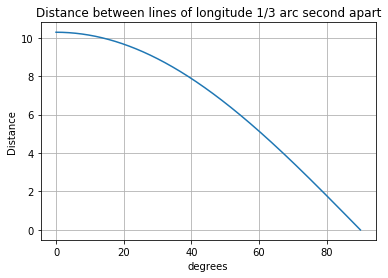

Notable Latitudes
49th parrallel (US-Canada border):  6.750847408312319
25.9 deg N (Brownsville, TX):  9.256449545448804
35.0 deg (LA):  8.429074535733726
40.7 deg (NYC):  7.80120231947384


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
deg = np.arange(0.0, 90.01, 0.01)

def deg2dist(deg): return 10.29 * np.cos(np.pi / 180 * deg)
dist = deg2dist(deg)

# Note that using plt.subplots below is equivalent to using
# fig = plt.figure and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()
ax.plot(deg, dist)

ax.set(xlabel='degrees', ylabel='Distance',
       title='Distance between lines of longitude 1/3 arc second apart')
ax.grid()

fig.savefig("degrees_and_dist.png")
plt.show()

print("Notable Latitudes")
print("49th parrallel (US-Canada border): ", deg2dist(49))
print("25.9 deg N (Brownsville, TX): ", deg2dist(25.9))
print("35.0 deg (LA): ", deg2dist(35.0))
print("40.7 deg (NYC): ", deg2dist(40.7))

So how should we query points? 

I think I've given this problem a bit more thought than it deserves for my purposes, but I'll type it out here. I'm not sure how the USGS decides what single elevation should represent an area of land, but if I were them, I would either go for the the median elevation that appears to represent land in their point cloud, or I would try and represent a point towards the middle of the block. In either case, most slopes in life are rather continious, so the two should be simmilar

## Defining the problem
To calculate the acceleration of of a wheeled object on an incline (or lack thereof), we must consider its mass and the forces acting upon it, namely, the acceleration due to gravity, the wheel's internal bearing friction, the rolling friction, and air resistance. The former 3 contribute forces porportional to the sine of the incline; the latter is the daily work of thousands of engineers.

## Reducing the problem's complexity

A core part of finding any algorithm is taking a node and checking all adjacent nodes to see if an adjacent node's speed can be improved by travelling through a road segment. Unfortunately, our formula to calculate the speed after going through a node requires a numerical integration, so it's kinda slow. We can approximate a solution by instead looking at the energy gained or lost going through the segment if air did not exist. We use these to find the optimal paths, then we use these paths and get a more precise simulation using our fancy formula.

How much does air matter? v0 ** 2 

In [2]:
g = -9.81 #accelertion due to gravity, m/s
drag_c = .6 #drag coefficient of human body
cross_a = .68 #Cross-sectional area of human body
mass = 80 #kg
frict_c = .03 #Coefficient of friction
import math

def acceleration_due_to_wind(v):
    return -v**2 * (1.225 * drag_c * cross_a) / (2 * mass)
def acceleration_due_to_slope_no_friction(theta):
    return g * math.sin(theta)

Solving for theta and finding the equivelent slope of the angle...

In [3]:
def equivalent_slope(v):
    return math.tan(math.asin(acceleration_due_to_wind(v) / g))

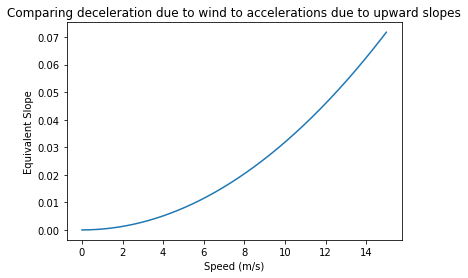

In [4]:
t = np.arange(0.0, 15.0, 0.01)
s = [equivalent_slope(v) for v in t]
plt.plot(t, s)
plt.xlabel('Speed (m/s)')
plt.ylabel('Equivalent Slope')
plt.title('Comparing deceleration due to wind to accelerations due to upward slopes')
plt.show()

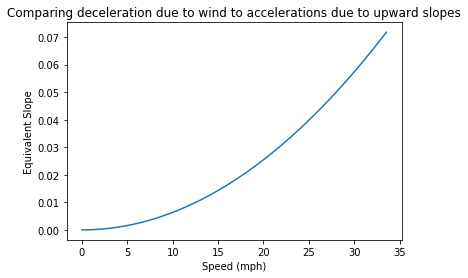

In [5]:
t = np.arange(0.0, 15.0, 0.01)
s = [equivalent_slope(v) for v in t]
t = t * 2.237
plt.plot(t, s)
plt.xlabel('Speed (mph)')
plt.ylabel('Equivalent Slope')
plt.title('Comparing deceleration due to wind to accelerations due to upward slopes')
plt.show()

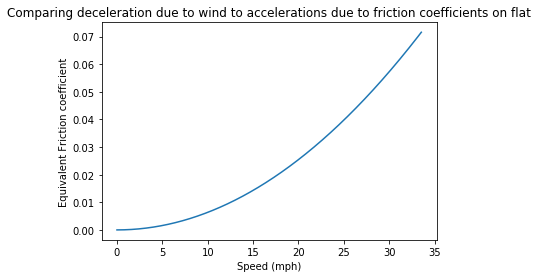

In [6]:
t = np.arange(0.0, 15.0, 0.01)
s = [acceleration_due_to_wind(v)/(g) for v in t]
t = t * 2.237
plt.plot(t, s)
plt.xlabel('Speed (mph)')
plt.ylabel('Equivalent Friction coefficient')
plt.title('Comparing deceleration due to wind to accelerations due to friction coefficients on flat')
plt.show()

It's actually pretty bad lol

## Solving the problem

I've thought a lot about this problem, first talking about doing DFS and BFS based approaches from points of local maxima (and programming it), then talking about doing Djikstra-inspired algorithms with steeper slopes or fastest route expansions first. After taking Algorithms, I realize that the key to solving this is to minimize duplicate work! I present 2 algorithms.

The second looks at the highest elevation nodes first

* We can label each node with the speed at which we can start _speed_, typically 1 m/s for longboards, then set to previous node _prev_ to **None**.

* Consider the highest elevation node on our map. It would make sense for routes to start here, since all routes to this point are uphill. For each adjacent node, we can the edit the node's _prev_ and _speed_ with the new highest speed if it is indeed higher.

* If we change a node's speed that is uphill from a node, we much re-update all of its adjacent nodes speeds, then recurse on all nodes updated above the original node

We can also do more simple depth-first and breadth-first search approaches, where the first paths start from the highest node on the graph, then subsequent paths start from lower nodes on the graph which have not been incorportated into another path yet. Basically, we must keep a set of nodes that still need to be expanded, and we can also can keep some data structure to sort those nodes, which may possibly contain duplicates. One option for this data structure is to have a priority queue with the highest elevation nodes first.

# Implementing

Let's start by downloading elevation data for a query. We query by using a simple dict.

In [7]:
data = {
    'north': 33.7874, 
    'west':  -84.4203, 
    'south': 33.7677,
    'east':  -84.3812, 
}


In [8]:
import wget
from scan_product_links import urls
import math
import os
us_urls = urls("elevationproductslinks/13secondplots.csv")
mx_ca_urls = urls("elevationproductslinks/1secondplots.csv")
def download_coords(data, country='United States'):
    # TODO check if request is gucci
    # TODO Remove the following block of code in production
    if country == 'United States':
        path_suffix = '_13'
        useful_urls = us_urls
    else:
        path_suffix = '_1'
        useful_urls = mx_ca_urls
    for lat in range(
        math.ceil(float(data['south'])), math.ceil(float(data['north'])) + 1
        # Eg N 87.7 to N 86.
        ):
        for lng in range(
            math.floor(float(data['west'])), math.floor(float(data['east'])) + 1
            ):
            fname = ('grd' + ('n' if lat>0 else 's')
                + str(abs(math.ceil(lat))).zfill(2)
                + ('e' if lng>=0 else 'w')
                + str(abs(math.floor(lng))).zfill(3))
            database_path = ('elevationdata/'
                + fname
                + path_suffix + '/w001001.adf'
                )
            if not os.path.exists(database_path):
                try:
                    print("downloading" + useful_urls[(lat, lng)] + "\n")
                    wget.download(useful_urls[(lat, lng)])
                    print("\n")
                    file_name = useful_urls[(lat, lng)].split('/')[-1]
                    archive = zipfile.ZipFile(file_name)
                    for file in archive.namelist():
                        if file.startswith("grd" + fname[3:] + path_suffix + "/"):
                            archive.extract(file, "elevationdata")
                    os.remove(file_name)
                except (urllib.error.HTTPError):
                    print("Could not download data for", (lat, lng))
                except KeyError:
                    print("Thing not found in urls: " (lat, lng))

In [9]:
download_coords(data)

In [10]:
mapsize = (
            data['west'],
            data['south'],
            data['east'],
            data['north']
            )

Next, we query OpenStreetMap for the map data!

In [11]:
import subprocess
import math
import osmapi
import os.path
import pickle
def get_map_data(mapsize):
    mapfilepath = 'maps/map'+str(mapsize)+'.dat'
    # TODO Allow spanning countries
                        # (west, south, east, north), string

    api_link = osmapi.OsmApi(#username='evanxq1@gmail.com',
                             #password='hrVQ*DO9aD9q'#,
                             #api="api06.dev.openstreetmap.org"
                             )
    try:
        if os.path.exists(mapfilepath):
            print('loading local map...')
            with open(mapfilepath, 'rb') as f:
                map_data = pickle.load(f)
        else:
            print('requesting map...')
            map_data = api_link.Map(mapsize[0], mapsize[1],
                                    mapsize[2], mapsize[3])
            with open(mapfilepath, 'wb') as f:
                pickle.dump(map_data, f) # TODO delete this entire try block tbh

    except IOError as e:
        print("Couldn't write map data!", e.errorno, e.strerror)

#     except Error as e: # osmapi.OsmApi.MaximumRetryLimitReachedError:  #TODO: handle errors
#         print(e.errorno, e.strerror)
#         print("Could not get map data!")
#         return False, [], [], [], [], [], []
    return map_data

In [12]:
get_map_data(mapsize)

loading local map...


[{'data': {'changeset': 21752899,
   'id': 69097091,
   'lat': 33.765318,
   'lon': -84.391904,
   'tag': {'highway': 'traffic_signals'},
   'timestamp': datetime.datetime(2014, 4, 17, 16, 56, 57),
   'uid': 1946151,
   'user': 'Jack the Ripper',
   'version': 4,
   'visible': True},
  'type': 'node'},
 {'data': {'changeset': 12331089,
   'id': 69097092,
   'lat': 33.765317,
   'lon': -84.393102,
   'tag': {},
   'timestamp': datetime.datetime(2012, 7, 19, 14, 23, 22),
   'uid': 330773,
   'user': 'Roadrunner21',
   'version': 3,
   'visible': True},
  'type': 'node'},
 {'data': {'changeset': 12331089,
   'id': 69097094,
   'lat': 33.76533,
   'lon': -84.3945719,
   'tag': {},
   'timestamp': datetime.datetime(2012, 7, 19, 14, 23, 22),
   'uid': 330773,
   'user': 'Roadrunner21',
   'version': 3,
   'visible': True},
  'type': 'node'},
 {'data': {'changeset': 3110547,
   'id': 69097099,
   'lat': 33.765343,
   'lon': -84.396128,
   'tag': {},
   'timestamp': datetime.datetime(2009, 11,

In [13]:
map_data = get_map_data(mapsize)

loading local map...


We need to turn the map into a usable graph structure now!

Possible optimization: right now I have each node store its neighbors in IDs and as pointers. Since pointer dereferencing is slow, what we really want to do is to assign a zero-indexed ID to each node so it can be referenced in a list.

In [165]:
# Todo add to node ititialziation

class Node:
    def __init__(self, node_id, lat, lng, is_stoplight, adj):
        self.node_id = node_id
        self.lat = lat
        self.lng = lng
        self.is_stoplight = is_stoplight
        self.adj = adj
        self.edge_coords = None
        self.edge_elevations = []
        self.edge_work = []
    def __lt__(self, other):
        return False
    def __gt__(self, other):
        return False
    def create_adj_node_ptrs(self):
        self.adj_node_ptrs = list(nodes[adj_node_id] for adj_node_id in self.adj)

In [217]:
# TODO support bridges
data['allow_bridges'] = False
data['banned_highway_types'] = [
    'motorway', 'trunk', 'service', 'steps', 'footway', 'pedestrian', 'sidewalk', 'path'
] 
                                # Also may include primary, secondary
# Highway type descriptions https://wiki.openstreetmap.org/wiki/Key:highway
#     motorway: interstate
#     trunk: mostly grade-separated state/us highways, always with medians
#     primary: major roads 
#     footway: exclusively pedestrians
#     sidewall: always on side of road
#     pedestrian: pedestrian oriented path, but not sidewalk
#     steps: stairsteps
#     path: trail
#     bridleway: horse trail
from collections import defaultdict
def map_to_graph(map_data):
    banned_types = set(data['banned_highway_types'])
    graph = defaultdict(set)
    for entry in map_data:
        if (entry['type'] == 'way'
                and 'data' in entry.keys()
                and 'tag' in entry['data'].keys()
                and 'highway' in entry['data']['tag'].keys()
                   ):
            highway_type = entry['data']['tag']['highway']
        else: # Is not labelled highway
            continue
        if (True
                and highway_type not in banned_types
                and (data['allow_bridges'] or ('bridge' not in entry['data']['tag']))
        ):
            road_nodes = entry['data']['nd']
            for i in range(len(road_nodes) - 1):
                graph[road_nodes[i]].add(road_nodes[i+1])
                graph[road_nodes[i+1]].add(road_nodes[i])
    return graph

In [218]:
adj_list = map_to_graph(map_data)

In [219]:
def get_node_entries(target_nodes, map_data):
    for item in map_data:
        item_id = item["data"]["id"]
        if item_id in target_nodes:
            yield (item_id, item)

In [220]:

node_lat_lng = []
datapts_per_degree = 10800
def create_node_list_with_elevations(adj_list, map_data):
    nodes = dict()
    node_heights, node_latlons = dict(), dict()
    stoplights = set()
    for node_id, node_info in get_node_entries(adj_list.keys(), map_data):
        nodes[node_id] = Node(
            node_id,
            lat=float(node_info['data']['lat']), 
            lng=float(node_info['data']['lon']),
            is_stoplight = 
                ('tag' in node_info['data'] and 'highway' in node_info['data']['tag']
                    and node_info['data']['tag']['highway'] == 'traffic_signals'
                ),
            adj = list(adj_list[node_id])
        )
    return nodes

In [221]:
nodes = create_node_list_with_elevations(adj_list, map_data)

In [222]:
for node_id, node in nodes.items():
    node.create_adj_node_ptrs()

In [223]:
import numpy as np
datapts_per_degree = 10800
def add_edges_return_queries(nodes):
    large_query = set()
    for node_id, node in nodes.items():
        edge_coords = []
        for adj_node in node.adj_node_ptrs:
            # Degrees aren't squares, so this isn't super valid, but it's not important.
            dist_in_degs = np.sqrt((node.lat - adj_node.lat)**2 + (node.lng - adj_node.lng)**2)
            n_steps = max(int(dist_in_degs * datapts_per_degree), 2)
            lat_steps = np.linspace(node.lat, adj_node.lat, num=n_steps, endpoint=True)
            lng_steps = np.linspace(node.lng, adj_node.lng, num=n_steps, endpoint=True)
            coords = list(zip(lat_steps, lng_steps))
            edge_coords.append(coords)
            large_query.update(coords)
        node.edge_coords = edge_coords
    return large_query


In [224]:
large_query = add_edges_return_queries(nodes)

In [225]:
# Make sure each node's edges start with the same coordinates
def test_edge_coords_start(nodes):
    for node_id, node in nodes.items():
        first = (node.lat, node.lng)
        for edge in node.edge_coords:
            assert edge[0] == first
test_edge_coords_start(nodes)
# Make sure each node's edges end with the same coordinates 
# as its adjacent node's start with
def test_edge_coords_end(nodes):
    for node_id, node in nodes.items():
        assert len(node.edge_coords) == len(node.adj) == len(node.adj_node_ptrs)
        for i in range(len(node.adj_node_ptrs)):
            assert (node.adj_node_ptrs[i].lat, node.adj_node_ptrs[i].lng) == node.edge_coords[i][-1]
test_edge_coords_end(nodes)

Possible optimization here: instead of +=ing a bunch of strings, we could use a stringbuilder type object

In [226]:
from collections import defaultdict
def build_query_text(large_query, country="United States"):
    queries = defaultdict(str)
    latlng_order = defaultdict(list)
    for lat_lng in large_query:
        lat, lng = lat_lng
        fname = ('grd' + ('n' if lat>0 else 's')
                 + str(abs(math.ceil(lat))).zfill(2)
                 + ('e' if lng>=0 else 'w') # lng = 0 block is all east I guess
                 + str(abs(math.floor(lng))).zfill(3)
                 )

        s = str(lng) + ' ' + str(lat) + '\n'
        queries[fname] += s
        latlng_order[fname].append(lat_lng)
    return queries, latlng_order

def query_elevations(queries, latlng_order, country="United States"):
    points = []
    elevations = []
    for fname in queries.keys():
        if country == 'United States': # TODO deal with AK
            database_path = 'elevationdata/' + fname + '_13/w001001.adf'
        if country == 'Mexico' or country == 'Canada' or country == None:
            # TODO deal with country == None which would be sorta weird
            database_path = 'elevationdata/' + fname + '_1/w001001.adf'
        proc = subprocess.Popen(
            ['gdallocationinfo', database_path, '-valonly', '-geoloc'],
            stdin=subprocess.PIPE, stdout=subprocess.PIPE,
            universal_newlines=True
        )
        output, err = proc.communicate(queries[fname])
        elevations += [float(s) for s in output.splitlines()]
        points += latlng_order[fname]
    if len(points) != len(elevations):
        raise Exception("Error querying points: " + str(len(points)) + " points, " + str(len(elevations)) + " elevations")
    ret = dict()
    for i in range(len(points)):
        ret[points[i]] = elevations[i]
    return ret

In [227]:
queries, latlng_order = build_query_text(large_query, country="United States")

In [228]:
elevations = query_elevations(queries, latlng_order, country="United States")

In [229]:
def set_node_elevations(nodes, elevations):
    for node_id, node in nodes.items():
        for edge in node.edge_coords:
            elevation_list = []
            for coord_pair in edge:
                elevation_list.append(elevations[coord_pair])
            node.edge_elevations.append(elevation_list)

In [230]:
set_node_elevations(nodes, elevations)

How nice! Now we need to decide what kind of edges we need to split on due to elevation differences. Let's test some stuff out.

In [231]:
deviations = []
high_deviations = []
low_deviations = []
for node_id, node in nodes.items():
    for i, edge in enumerate(node.edge_elevations):
        bottom_end = min(edge[0], edge[-1])
        top_end = max(edge[0], edge[-1])
        top = max(edge)
        bottom = min(edge)
        deviations.append(max(top-top_end, bottom_end-bottom))
        high_deviations.append(top-top_end)
        low_deviations.append(bottom_end-bottom)

In [232]:
print(0, len(deviations))
print(.01, sum([i >= .01 for i in deviations]))
print(.1, sum([i >= .1 for i in deviations]))
print(.3, sum([i >= .3 for i in deviations]))
print(1, sum([i >= 1 for i in deviations]))
print(3, sum([i >= 3 for i in deviations]))
print(5, sum([i >= 5 for i in deviations]))

0 6846
0.01 766
0.1 580
0.3 340
1 120
3 24
5 10


Note that all values are even since our graph is directed, so there are edges going in each direction. Here's a question: since we've been storing all the adjacent edges of each graph as a random ordered list, what is the expected runtime of finding the opposite edge to split if we split over 1 meter?

In [233]:
edges_to_scan = 0
for node_id, node in nodes.items():
    for i, edge in enumerate(node.edge_elevations):
        bottom_end = min(edge[0], edge[-1])
        top_end = max(edge[0], edge[-1])
        top = max(edge)
        bottom = min(edge)
        edges_to_scan += len(node.edge_elevations)
print(edges_to_scan/4) # over 4 rather than 2 since we only have to look at "opposite" nodes from the ones we split

3967.0


I've seen better, but it's not worth doing anything about now. Road graphs are always kind of sparse, so I imagine this would increase somewhat linearly with edge total. Programming splitting sounds like a pain, though. I'll do it later (tm)

In [234]:
data['mass'] = 80 #kg
data['init_speed'] = 1.0
data['use_stoplights'] = True

In [235]:
def prep_graph(nodes):
    init_energy = .5 *data['mass'] * data['init_speed'] ** 2
    for node_id, node in nodes.items():
        node.energy = init_energy
        node.speed = data['init_speed']
        node.prev_node = None
        node.next_nodes = set()
        node.path_start = node
        # TODO add to some other method
        node.elevation = node.edge_elevations[0][0]

In [236]:
prep_graph(nodes)

Here comes that big dramatic |V|log|V| sort that all CS classes have been prepraring me for!!

In [237]:
sorted_nodes = sorted(nodes.values(), key=lambda n: -n.elevation)

Well that was quick. Let's get to the «physics»

In [238]:
g = -9.81 #accelertion due to gravity, m/s
data['drag_c'] = .6 #drag coefficient of human body
data['cross_a'] = .68 #Cross-sectional area of human body
data['mass'] = 80 #kg
data['frict_c'] = .03 #Coefficient of friction
import math

def prep_data_constants(data):
    data['c1'] = (1.225 * data['drag_c'] * data['cross_a']) / (2 * data['mass'])
    data['c2'] = g * data['frict_c']
def new_velocity(v0, dh, dist): # for small changes in V; dist is horizontal dist
    if v0 == 0:
        return 0

    theta = math.atan2(dh, dist)
    # Original implementation
#     a = ((g * math.sin(theta))
#          - (1.225 * drag_c * cross_a * v0 ** 2) / (2 * mass)
#          + (g * frict_c * math.cos(theta))
#         )
    # Prematurely optimized (tm) implementation
    a = ((g * math.sin(theta))
         - v0 ** 2 * data['c1']
         + math.cos(theta) * data['c2']
        )
        # Total Acceleration = grav, air resistance, rolling friction resistance
        # Assumes final velocity causes about the amount of air resistance as
        #   inital velocity
    vel_sqr = 2 * a * math.sqrt(dist**2 + dh**2) + v0 ** 2
    if vel_sqr > 0:
        return math.sqrt(vel_sqr)
    else:
        return 0


In [239]:
prep_data_constants(data)

In [240]:
new_velocity(1.0, -2, 30)

4.732246713956515

In [241]:
new_velocity(1.0, -1, 30)

1.6656743090735213

Let's see what happens when we try to "integrate" this more precisely.

In [242]:
def new_velocity(v0, dh, dist, integrations=1): # for small changes in V; dist is horizontal dist
    if v0 == 0:
        return 0

    theta = math.atan2(dh, dist)
    # Original implementation
#     a = ((g * math.sin(theta))
#          - (1.225 * drag_c * cross_a * v0 ** 2) / (2 * mass)
#          + (g * frict_c * math.cos(theta))
#         )
    # Prematurely optimized (tm) implementation
    v = v0
    dist_per_i = dist/integrations
    dh_per_i = dh/integrations
    for i in range(integrations):
        a = ((g * math.sin(theta))
             - v ** 2 * data['c1']
             + math.cos(theta) * data['c2']
            )
            # Total Acceleration = grav, air resistance, rolling friction resistance
            # Assumes final velocity causes about the amount of air resistance as
            #   inital velocity
        vel_sqr = 2 * a * math.sqrt(dist_per_i**2 + dh_per_i**2) + v ** 2
        if vel_sqr > 0:
            v = math.sqrt(vel_sqr)
        else:
            return 0
    return v



In [243]:
def new_velocity_no_friction(v0, dh, dist): # for small changes in V; dist is horizontal dist
    integrations=1
    if v0 == 0:
        return 0

    theta = math.atan2(dh, dist)
    # Original implementation
#     a = ((g * math.sin(theta))
#          - (1.225 * drag_c * cross_a * v0 ** 2) / (2 * mass)
#          + (g * frict_c * math.cos(theta))
#         )
    # Prematurely optimized (tm) implementation
    v = v0
    dist_per_i = dist/integrations
    dh_per_i = dh/integrations
    for i in range(integrations):
        a = ((g * math.sin(theta))
             + math.cos(theta) * data['c2']
            )
            # Total Acceleration = grav, air resistance, rolling friction resistance
            # Assumes final velocity causes about the amount of air resistance as
            #   inital velocity
        vel_sqr = 2 * a * math.sqrt(dist_per_i**2 + dh_per_i**2) + v ** 2
        if vel_sqr > 0:
            v = math.sqrt(vel_sqr)
        else:
            return 0
    return v

In [244]:
new_velocity_no_friction(1.0, -1, 30)

1.7210461934532721

In [245]:
new_velocity(1.0, -1, 30, 1)

1.6656743090735213

In [246]:
new_velocity(1.0, -1, 30, 10)

1.6223362027821746

In [247]:
new_velocity(1.0, -1, 30, 100)

1.618456058926162

In [248]:
new_velocity(1.0, -1, 30, 1000)

1.6180720127338581

In [249]:
new_velocity(1.0, -1, 30, 10000)

1.6180336473064574

In [250]:
new_velocity_no_friction(1.0, -2, 30)

4.752052188265613

In [251]:
new_velocity(1.0, -2, 30, 1)

4.732246713956515

In [252]:
new_velocity(1.0, -2, 30, 10)

4.546802951678203

In [253]:
new_velocity(1.0, -2, 30, 100)

4.530077272712141

In [254]:
new_velocity(1.0, -2, 30, 1000)

4.528420663059089

In [255]:
new_velocity(1.0, -2, 30, 10000)

4.528255159751737

In [256]:
def latlong_dist(lat1_raw, lon1_raw, lat2_raw, lon2_raw):
    lat1 = math.radians(float(lat1_raw))
    lon1 = math.radians(float(lon1_raw))
    lat2 = math.radians(float(lat2_raw))
    lon2 = math.radians(float(lon2_raw))
    # approximate radius of earth in m
    R = 6373000.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2)
         * math.sin(dlon / 2)**2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

In [257]:

data['approx_frict_c'] = .03
def calculate_work(dist, dh): # Work done by gravity
    theta = math.atan2(dh, dist)
    a = ((g * math.sin(theta))
     + math.cos(theta) * g * data['approx_frict_c']
    )
    real_dist = math.sqrt(dist**2 + dh**2)
    return real_dist * a * data['mass']

def find_work_all_edges(sorted_nodes):
    for node in sorted_nodes:
        node.edge_work = []
        for i in range(len(node.adj)):
            edge_coords = node.edge_coords[i]
            edge_elevations = node.edge_elevations[i]
            work = 0
            horiz_dist = latlong_dist(edge_coords[0][0], edge_coords[0][1], 
                                      edge_coords[1][0], edge_coords[1][1])
            for j in range(len(edge_coords) - 1): 
                dh = edge_elevations[j+1] - edge_elevations[j]
                # horiz dist is actually same for each part of an edge
                #  horiz_dist = latlong_dist(edge_coords[j][0], edge_coords[j][1], edge_coords[j+1][0], edge_coords[j+1][1])
                work += calculate_work(horiz_dist, dh)
            node.edge_work.append(work)

In [258]:
find_work_all_edges(sorted_nodes)

In [259]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc

# lines = [[(0, 1), (1, 1)], [(2, 3), (3, 3)], [(1, 2), (1, 3)]]
# c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])


def graph_paths(sorted_nodes):
    lines = []
    colors = []
    max_lat = -90
    min_lat = 90
    max_lng = -180
    min_lng = 180
    done = set()
    for node in sorted_nodes:
        max_lat = max(node.lat, max_lat)
        min_lat = min(node.lat, min_lat)
        max_lng = max(node.lng, max_lng)
        min_lng = min(node.lng, min_lng)
        for adj in node.next_nodes:
            if ((adj.lng,adj.lat), (node.lng, node.lat)) not in done:
                lines.append([(node.lng, node.lat),(adj.lng,adj.lat)])
                done.add(((node.lng, node.lat),(adj.lng,adj.lat)))
    colors = []
    for line in lines:
        beginning, end = line
        x1, y1 = beginning
        x2, y2 = end
        angle = math.atan2(x2-x1, y2-y1)
        colors.append((math.cos(angle) * .5 + .5,  math.sin(angle) * .5 + .5, 0, 1))
    lc = mc.LineCollection(lines, colors=colors, linewidths=1)
    fig, ax = pl.subplots(figsize=(16,10))
    ax.add_collection(lc)
    # ax.autoscale()
    # ax.margins(0.001)
    ax.set_xlim(min_lng, max_lng)
    ax.set_ylim(min_lat, max_lat)
    plt.show()

In [267]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc

# lines = [[(0, 1), (1, 1)], [(2, 3), (3, 3)], [(1, 2), (1, 3)]]
# c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])
def generate_compass():
    lines = []
    for x in [-1, -.5, 0, .5, 1]:
        for y in [-1, -.5, 0, .5, 1]:
            if (x, y) != (0,0):
                lines.append([(0,0), ((x,y))])
    colors = []
    for line in lines:
        beginning, end = line
        x1, y1 = beginning
        x2, y2 = end
        angle = math.atan2(x2-x1, y2-y1)
        colors.append((math.cos(angle) * .5 + .5,  math.sin(angle) * .5 + .5, 0, 1))
    lc = mc.LineCollection(lines, colors=colors, linewidths=1)
    fig, ax = pl.subplots()
    ax.add_collection(lc)
    ax.autoscale()
    # ax.margins(0.001)
    plt.show()

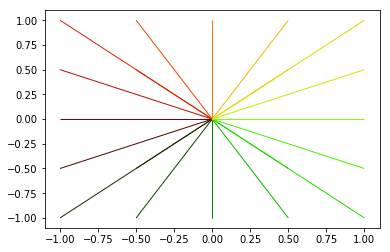

In [268]:
generate_compass()

In [262]:
# Adding this for reference
# class Node:
#     def __init__(self, node_id, lat, lng, is_stoplight, adj):
#         self.node_id = node_id
#         self.lat = lat
#         self.lng = lng
#         self.is_stoplight = is_stoplight
#         self.adj = adj
#         self.edge_coords = None
#         self.edge_elevations = []
#     def create_adj_node_ptrs(self):
#         self.adj_node_ptrs = list(nodes[adj_node_id] for adj_node_id in self.adj)
#     node.speed = data['init_speed']
#     node.prev_node = None
#     node.path_start = node
#     # TODO add to some other method
#     node.elevation = node.edge_elevations[0][0]

# g = -9.81 #accelertion due to gravity, m/s
# data['drag_c'] = .6 #drag coefficient of human body
# data['cross_a'] = .68 #Cross-sectional area of human body
# data['mass'] = 80 #kg
# data['frict_c'] = .03 #Coefficient of friction
# def prep_data_constants(data):
#     data['c1'] = (1.225 * data['drag_c'] * data['cross_a']) / (2 * data['mass'])
#     data['c2'] = g * data['frict_c']

### Attempt #1: Djikstra inspired

In [263]:
from heapq import heappush, heappop
def algo_1(sorted_nodes):
    edges_explored = 0
    for top_node in sorted_nodes:
        if top_node.prev_node != None: # Already part of a path
            continue
        need_to_explore = set([top_node])
        heap = [(-top_node.elevation, top_node)]
        while need_to_explore:
            _, node = heappop(heap)
            if node not in need_to_explore:
                continue
            need_to_explore.remove(node)
            node_energy = node.energy
            for i in range(len(node.adj)):
                adj = node.adj_node_ptrs[i]
                edge_work = node.edge_work[i]
                # For air resistance version, check first if 
                #      (node.speed > adj.speed or node.elevation > adj.elevaton)
                # then ride down nodes
                if edge_work + node_energy > adj.energy:
                    adj.energy = edge_work + node_energy
                    if adj.prev_node is not None:
                        prev = adj.prev_node
                        next_nodes = prev.next_nodes
                        next_nodes.remove(adj)
                    adj.prev_node = node
                    node.next_nodes.add(adj)
                    adj.path_start = top_node
                    need_to_explore.add(adj)
                    heappush(heap, (-adj.elevation, adj))
                edges_explored += 1
    return edges_explored

In [264]:
prep_graph(nodes) # reset graph
algo_1(sorted_nodes)

8624

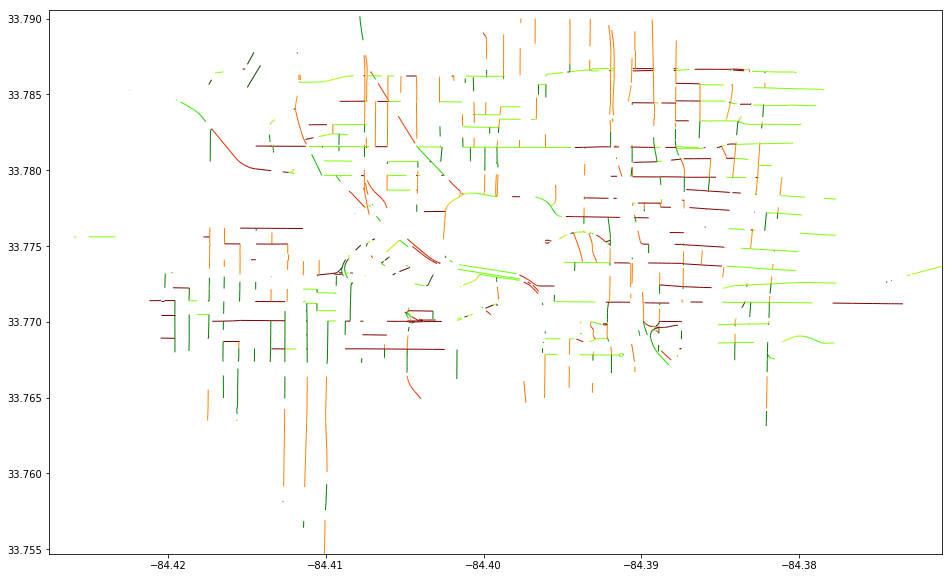

In [265]:
graph_paths(sorted_nodes)

In [266]:
def test_nodes(sorted_nodes):
    for node in sorted_nodes:
        for adj in node.adj_node_ptrs:
            if adj in node.next_nodes:
                assert adj.prev_node == node
            else:
                assert adj.prev_node != node
test_nodes(sorted_nodes)